<a href="https://colab.research.google.com/github/michaeledge27/CSCI290/blob/main/notebooks/kMeansClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
iris = load_iris()

In [3]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [4]:
df["species"] = iris.target

In [5]:
target_names = {
    0: "setosa",
    1: "versicolor",
    2: "virginica"
}

df["species_name"] = df["species"].map(target_names)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


In [6]:
df2 = df.copy().drop(columns=["species_name"])
df2

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


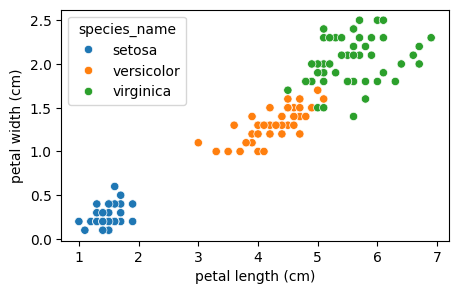

In [7]:
plt.figure(figsize=(5, 3))
sns.scatterplot( x = "petal length (cm)", y = "petal width (cm)", data = df, hue = "species_name");

In [8]:
df = df.drop(columns=["species", "species_name"])

In [9]:
df[['current_cluster']] = -1
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),current_cluster
0,5.1,3.5,1.4,0.2,-1
1,4.9,3.0,1.4,0.2,-1
2,4.7,3.2,1.3,0.2,-1
3,4.6,3.1,1.5,0.2,-1
4,5.0,3.6,1.4,0.2,-1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,-1
146,6.3,2.5,5.0,1.9,-1
147,6.5,3.0,5.2,2.0,-1
148,6.2,3.4,5.4,2.3,-1


# k-Means Algorithm

In [10]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

In [11]:
# return random sample of k initial centroids
def get_random_centroids(df, k):
    return df.sample(k)[df.columns[:-1]]

In [12]:
get_random_centroids(df, 3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
34,4.9,3.1,1.5,0.2
45,4.8,3.0,1.4,0.3
70,5.9,3.2,4.8,1.8


In [13]:
get_random_centroids(df, 3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
149,5.9,3.0,5.1,1.8
13,4.3,3.0,1.1,0.1
17,5.1,3.5,1.4,0.3


In [14]:
# compare old centroids to new centroids to see if the algorithm has converged yet
# return true if new_centroids is equal to old_centroids, false otherwise
def check_new_centroids(old_centroids, new_centroids):
    if old_centroids.empty:
        return False  # Return False at start of loop
    return np.allclose(old_centroids.values, new_centroids.values, atol=0.001)

In [15]:
def update_centroids(df):
    return df.groupby("current_cluster").mean()[df.columns[:-1]]


In [16]:
# plot data and centroids for each iteration
def plot_clusters(df, centroids, iteration):
    plt.figure(figsize=(5, 3))

    # Plot each cluster
    sns.scatterplot(x = "petal length (cm)", y = "petal width (cm)", data = df, hue = "current_cluster");

    # Plot the centroids
    plt.scatter(
        centroids["petal length (cm)"], centroids["petal width (cm)"],
        color="red", marker="X", s=200, label="Centroids"
    )

    plt.title(f'Iteration {iteration}')
    plt.xlabel("petal length (cm)")
    plt.ylabel("petal width (cm)")
    plt.legend()
    plt.show()
    plt.pause(1)
    clear_output(wait=True)


In [17]:
def get_cluster(df, centroids, plot=True):
    # initialize old centroids as an empty dataframe
    old_centroids = pd.DataFrame()
    # keep track of what iteration we are on for plotting
    iteration = 0
    # run iteratively while the new centroids are different from the old ones
    while not check_new_centroids(old_centroids, centroids):
        # update the old centroids
        old_centroids = centroids.copy()
        # iterate over each point in the data frame
        for i in df.index:
            # store distances from current point to each centroid
            distances = []
            # iterate over each centroid
            for _, centroid in centroids.iterrows():
                # calculate euclidean distance from current point to current centroid
                distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], centroid))
            # assign the point to the cluster with the closest centroid
            closest_cluster = np.argmin(distances)
            df.loc[i, 'current_cluster'] = closest_cluster

        if plot:
          # plot clusters and centroids
          plot_clusters(df, centroids, iteration)
        #update centroids
        centroids = update_centroids(df)
        iteration += 1
    return df


In [18]:
get_random_centroids(df, 3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
145,6.7,3.0,5.2,2.3
73,6.1,2.8,4.7,1.2
88,5.6,3.0,4.1,1.3


In [19]:
get_cluster(df, get_random_centroids(df, 3))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),current_cluster
0,5.1,3.5,1.4,0.2,2
1,4.9,3.0,1.4,0.2,2
2,4.7,3.2,1.3,0.2,2
3,4.6,3.1,1.5,0.2,2
4,5.0,3.6,1.4,0.2,2
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0
146,6.3,2.5,5.0,1.9,1
147,6.5,3.0,5.2,2.0,0
148,6.2,3.4,5.4,2.3,0


# Accuracy

In [20]:
def calculate_accuracy(df, clustered_df, target='species'):
    accuracy = 0
    for i in df.index:
        if df.loc[i, target] == clustered_df.loc[i, 'current_cluster']:
            accuracy += 1
    return accuracy / len(df)

# Inertia Method

In [21]:
def get_inertia(df, centroids):
    # initialize as 0
    inertia = 0
    # loop through each point
    for i in df.index:
        # get cluster assignment
        cluster = df.loc[i, 'current_cluster']
        # calculate euclidean distance between the point and its assigned centroid
        distance = euclidean_distance(df.loc[i, df.columns[:-1]], centroids.loc[cluster])
        # add the squared distance to the total inertia
        inertia += distance**2
    return inertia

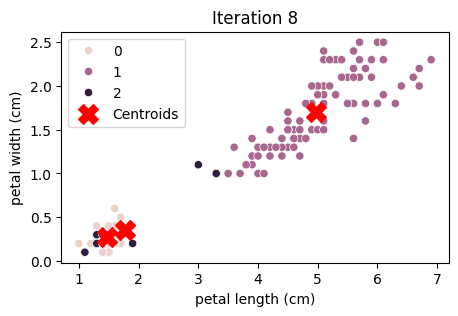

In [22]:
clustered_df = get_cluster(df, get_random_centroids(df, 3))

In [23]:
inertia = get_inertia(clustered_df, update_centroids(clustered_df))
inertia

142.75406250000006

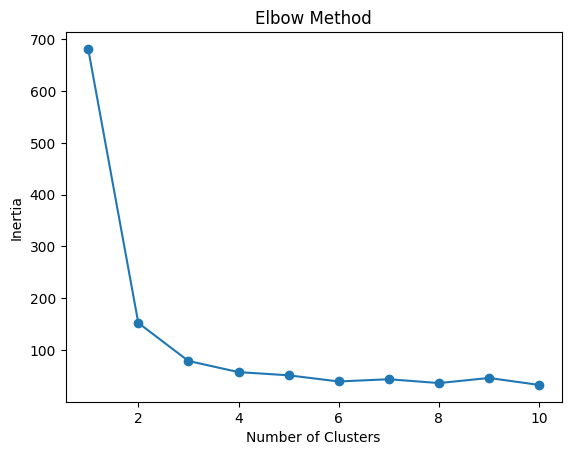

In [24]:
inertias = []
for i in range(1, 11):
    centroids = get_random_centroids(df, i)
    clustered_df = get_cluster(df, centroids, plot=False)
    inertia = get_inertia(clustered_df, update_centroids(clustered_df))
    inertias.append(inertia)


plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Initialize Centroids

In [25]:
def initialize_centroids(df, k):
    # initialize list to hold k centroids
    centroids = []
    # randomly select first centroid
    first_centroid = df.sample(1).iloc[0]
    # add it to the centroid list
    centroids.append(first_centroid)
    # get remaining k-1 centroids
    for i in range(1, k):     # k is exclusive
        # initialize list to hold distances from new centroids to the first centroid
        distances = []
        # loop through each point in the data frame
        for i in df.index:
            point = df.loc[i, df.columns[:-1]]
            # Calculate the distance from the current point to each centroid
            min_distance = min(euclidean_distance(point, centroid) for centroid in centroids)
            distances.append(min_distance**2)  # Append squared distance
        # compute probabilities
        probabilities = distances / np.sum(distances)
        # select new centroid
        new_centroid = df.sample(1, weights=probabilities).iloc[0]
        # add new centroid to list
        centroids.append(new_centroid)

    return pd.DataFrame(centroids, columns=df.columns[:-1])

In [26]:
get_cluster(df, initialize_centroids(df, 3))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),current_cluster
0,5.1,3.5,1.4,0.2,2
1,4.9,3.0,1.4,0.2,2
2,4.7,3.2,1.3,0.2,2
3,4.6,3.1,1.5,0.2,2
4,5.0,3.6,1.4,0.2,2
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,1
146,6.3,2.5,5.0,1.9,0
147,6.5,3.0,5.2,2.0,1
148,6.2,3.4,5.4,2.3,1


# Silhouette Coefficients

In [27]:
# calculate mean inter cluster distance (a_i)
def mean_icd(df, point_index):
    distances = []
    # get the current cluster of the point
    current_cluster = df.loc[point_index, 'current_cluster']
    # get all points in the current cluster
    cluster_points = df[df['current_cluster'] == current_cluster]
    # loop through all points in current cluster
    for i in cluster_points.index:
        # exclude the point itself
        if i != point_index:
            # calculate and append mean distance between the current point and all other points
            distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], df.loc[point_index, df.columns[:-1]]))

    return np.mean(distances) if distances else 0


In [28]:
# calculate mean nearest cluster distance (b_i)
def mean_ncd(df, point_index):
    total_distances = []
    # get the current cluster
    current_cluster = df.loc[point_index, 'current_cluster']
    # get all other clusters
    other_clusters = df[df['current_cluster'] != current_cluster]
    # loop through each unique cluster in other_clusters
    for cluster in other_clusters['current_cluster'].unique():
        # get all points belonging to the cluster being considered
        cluster_points = df[df['current_cluster'] == cluster]
        # compute distance to all points in the current cluster
        distances = []
        for i in cluster_points.index:
            # calculate distance between this point and each point in the current cluster
            distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], df.loc[point_index, df.columns[:-1]]))
        # calculate mean distance to the current cluster
        total_distances.append(np.mean(distances))
    # return minimum mean distance among all clusters
    return min(total_distances)


In [44]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),current_cluster
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0
146,6.3,2.5,5.0,1.9,4
147,6.5,3.0,5.2,2.0,4
148,6.2,3.4,5.4,2.3,0


In [52]:
def get_silhouette_coefficients(df):
    # get all points in the current cluster
    # df = df[df['current_cluster'] == cluster]
    # store coefficients for a cluster
    silhouette_coefficients = []
    # loop through each point in the cluster
    for i in df.index:
        # calculate mean inter cluster distance
        a = mean_icd(df, i)
        # calculate mean nearest cluster distance
        b = mean_ncd(df, i)
        # compute silhouette coefficient for each point
        silhouette_coefficients.append((b - a) / max(a, b))
    new_df = pd.DataFrame( { 'silhouette coefficient': silhouette_coefficients,
                                 'current_cluster': df['current_cluster'] } )
    # return silhouette coefficients for all points in the cluster
    return new_df


In [53]:
new_df = get_silhouette_coefficients(df)
new_df

,silhouette coefficient,current_cluster
0,0.053551,1
1,0.540135,1
2,0.564451,1
3,0.576354,1
4,0.043362,1
...,...,...
145,0.130512,0
146,0.239573,4
147,0.077531,4
148,0.030332,0


In [54]:
silhouette_score = np.mean(new_df['silhouette coefficient'])
silhouette_score

0.33084449618507356

In [63]:
centroids = initialize_centroids(df, 3)
clustered_df = get_cluster(df, centroids, plot=False)
new_df = get_silhouette_coefficients(clustered_df)
silhouette_score = np.mean(new_df['silhouette coefficient'])
coefficients = new_df['silhouette coefficient']
c_cluster = new_df['current_cluster']
coefficients.sort()
plt.plot(coefficients)

AttributeError: 'Series' object has no attribute 'sort'

In [57]:
from matplotlib.ticker import FixedLocator, FixedFormatter

In [71]:
coeffs = new_df[new_df['current_cluster'] == i]['silhouette coefficient']
coeffs

,silhouette coefficient
50,0.657389
51,0.672756
52,0.698824
53,0.451348
54,0.702137
...,...
145,0.724297
146,0.730283
147,0.747297
148,0.702502


In [73]:
coeffs = list(coeffs)
coeffs.sort()
coeffs

[0.07037110897521809,
 0.2159076200783045,
 0.2848054160617774,
 0.2994106237656984,
 0.35132545332135673,
 0.37112501271347487,
 0.4148236365748164,
 0.45134843271215236,
 0.46302239858718003,
 0.46342048890489446,
 0.4669314201949783,
 0.48429603054609777,
 0.49877067147434917,
 0.5024940780977317,
 0.5075047039863276,
 0.5355162256794885,
 0.5402170957407127,
 0.5447286023773424,
 0.5476303305733686,
 0.5584963688937361,
 0.5610923216952854,
 0.5818262218294394,
 0.5820240096036989,
 0.5834667415945142,
 0.5933486893755148,
 0.6003220587558895,
 0.61047799209663,
 0.6222444796928007,
 0.6231929110527972,
 0.6244349254239567,
 0.6264440373657046,
 0.6312274187030648,
 0.6328375950207497,
 0.6369576832832825,
 0.6383803460069131,
 0.6423984346872115,
 0.6433172375111814,
 0.6435800846906179,
 0.6546857906608707,
 0.6573893243789631,
 0.6607468782509571,
 0.6664213312513133,
 0.6727560669707155,
 0.6761500739212936,
 0.6779304635346051,
 0.6781122994965423,
 0.6792280924713388,
 0.6793

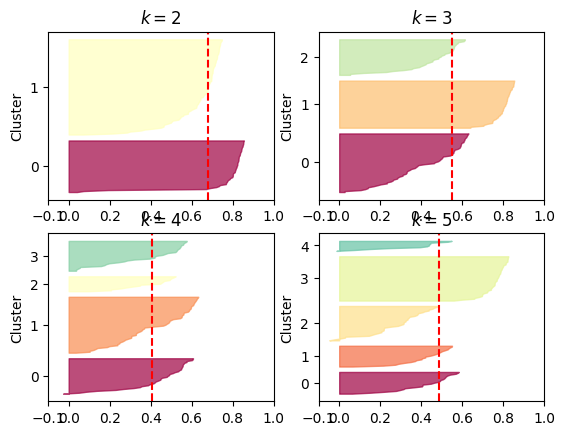

In [78]:
for k in range(2, 6):
    plt.subplot(2, 2, k-1)
    centroids = initialize_centroids(df, k)
    clustered_df = get_cluster(df, centroids, plot=False)
    new_df = get_silhouette_coefficients(clustered_df)
    silhouette_score = np.mean(new_df['silhouette coefficient'])
    padding = len(new_df) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = new_df[new_df['current_cluster'] == i]['silhouette coefficient']
        coeffs = list(coeffs)
        coeffs.sort()
        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    plt.ylabel("Cluster")

    plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.axvline(x=silhouette_score, color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.show()

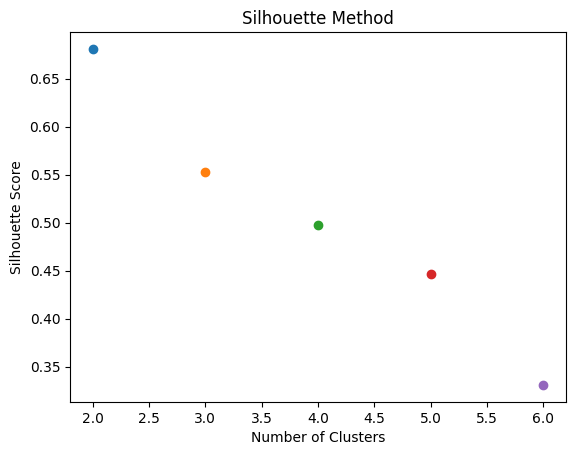

In [34]:
for k in range(2, 7):

    # centroids = initialize_centroids(df, k)
    # clustered_df = get_cluster(df, centroids, plot=False)
    # for cluster in clustered_df['current_cluster'].unique():
    #     cluster_points = clustered_df[clustered_df['current_cluster'] == cluster]
    #     sil_coefficients = get_silhouette_coefficients(cluster)
    # sil_score = np.mean(sil_coefficients)


    centroids = initialize_centroids(df, k)
    clustered_df = get_cluster(df, centroids, plot=False)
    cluster_points = clustered_df[clustered_df['current_cluster'] == cluster]
    sil_coefficients = get_silhouette_coefficients(clustered_df)
    sil_score = np.mean(sil_coefficients)
    sil_coefficients.sort()
    plt.plot(k, sil_score, marker='o')

plt.title('Silhouette Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

keep track/figure out which cluster each coefficient is assigned to, turn it into a dataframe and plot coefficients for each cluster using groupby and the mean of the coefficients for each value of k